# Plot intergenic region mutation spectra and coverages

Counterpart to the "Within-gene" notebook. This is a pared-down version of the code there (we don't need to care about, e.g., coloring dots by CP -- so a lot less work is needed).

I guess ideally both notebooks would use the same code that would just be highly adaptable, but... that seems like overkill. At least right now.

In [28]:
%run "Header.ipynb"
%run "LoadMutationJSONData.ipynb"

## Define utility functions for plotting

In [40]:
def plot_region_mutation_spectrum(seq, leftend, rightend, ax, cutoff=None):
    """leftend must be < rightend.
    
    "cutoff" can optionally be a float. If cutoff is not None, then this'll print out
    information about the number of positions where the percentage of mismatches is >= cutoff.
    (Mostly useful for adding to figure captions...)
    """
    if leftend > rightend:
        # as in highly mutated intergenic region notebook, this has to be ok with left = right since
        # that can actually happen.
        # course, idk why you'd be plotting that..., but you never know lol
        raise ValueError("leftend must be <= rightend")
        
    positions = range(leftend, rightend + 1)
    
    num_called_mutations = 0
    called_mutations_pcts = []
    called_mutations_positions = []
    
    # We don't call scatter() once for each position like in the within-gene plot ntbk -- instead, we do it
    # just once, after processing each position. This is because... we don't need to do that here, and this
    # is a lot faster lol.
    # (In fairness the within-gene ntbk could also be made a lot faster -- but not a priority right now)
    
    mutrates = []
    
    for p in positions:
        sp = str(p)
        cov = seq2pos2mismatchct[seq][sp] + seq2pos2matchct[seq][sp]
        pct = seq2pos2mismatchct[seq][sp] / cov
        mutrates.append(pct)

        if cutoff is not None and pct >= cutoff:
            num_called_mutations += 1
            called_mutations_pcts.append(pct)
            called_mutations_positions.append(p)
            
    ax.scatter(positions, mutrates, c="#138f13")
    
    if cutoff is not None:
        print("{} / {} positions have a mismatch rate >= the cutoff of {}".format(
            num_called_mutations, len(gene_positions), cutoff
        ))
        # Avoid printing details if no "mutations" were identified here -- mean() will throw an error, at least
        # as of writing, if passed an empty collection.
        if num_called_mutations > 0:
            print("Average mutation rate among these {} positions is {:.2f}%.".format(
                num_called_mutations, mean(called_mutations_pcts) * 100
            ))
            print("These exact positions are {}".format(called_mutations_positions))

    ax.set_title("Mutation spectrum")
    ax.set_ylabel(r"$\dfrac{\mathrm{Mismatches}}{\mathrm{Mismatches + Matches}}$")
    
    ax.set_ylim(0)
    
    max_mutation_pct = max(mutrates)
    
    # Make low-mutation-rate genes have more granularity in the y-axis tick labels (matplotlib
    # can do stuff like just show 0% for all ticks if we use decimals=0)
    # The reason we don't use decimals=None, the default (where we make matplotlib pick the level of granularity),
    # is that that seems to use too many decimals for our purposes (the docs admit that decimals=None has some
    # limitations: https://github.com/matplotlib/matplotlib/blob/22258133da1fd25e38a519b8fe1314d1ba513990/lib/matplotlib/ticker.py#L1624-L1626)
    # This approach isn't perfect either, but it's good enough. (TODO: figure out the optimal way to do this?)
    if max_mutation_pct < 0.005:
        decimals = 2
    elif max_mutation_pct < 0.05:
        decimals = 1
    else:
        decimals = 0
        
    print("Maximum mutation rate is {:.2f}%".format(max_mutation_pct * 100))
    # Disable "offset" on the x-axis. This prevents matplotlib from replacing literal sequence positions with
    # smaller numbers and then adding a "+1.21e6" off to the side of the axis (which is... a lot more confusing
    # for this particular application than just listing the actual sequence positions). Doing this *after* the
    # percentage thing below doesn't seem to work, but doing it up here works. I dunno, matplotlib is hard.
    # See https://stackoverflow.com/a/28373421.
    ax.ticklabel_format(useOffset=False)
    
    # Make the y-axis show percentages: based on
    # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=decimals))
    
    # Use thousands separator on the x-axis
    use_thousands_sep(ax.get_xaxis())

In [41]:
def plot_region_coverage(seq, leftend, rightend, ax):
    if leftend > rightend:
        # as in highly mutated intergenic region notebook, this has to be ok with left = right since
        # that can actually happen.
        # course, idk why you'd be plotting that..., but you never know lol
        raise ValueError("leftend must be <= rightend")
        
    positions = range(leftend, rightend + 1)

    all_covs = [seq2pos2totalcov[seq][str(p)] for p in positions]
    ax.scatter(positions, all_covs, c="#138f13")
    
    print("The lowest-coverage position in this entire gene has coverage {:,}x.".format(min(all_covs)))
    print("This gene has an average coverage of {:,}x.".format(mean(all_covs)))
    print("...(The sum of all positions' coverages is {:,}x, for reference.)".format(sum(all_covs)))
    ax.set_title("Coverage")
    ax.set_xlabel("Sequence position")
    ax.set_ylabel("Mismatches + Matches")
    
    ax.ticklabel_format(useOffset=False)
    use_thousands_sep(ax.get_xaxis())
    use_thousands_sep(ax.get_yaxis())

In [45]:
def mutation_spectrum_and_coverage_plots(seq, left, right, cutoff=None):
    """Plots a region's mutation spectrum and coverage.
    
        seq: str
        
        left: int
            1-indexed left end, inclusive
        
        right: int
            1-indexed right end, inclusive
        
        cutoff: float (optional)
            This is passed to plot_mutation_spectrum() -- see docs of that.
    """
    
    fig, (ax1, ax2) = pyplot.subplots(2)
    print("=" * 79)
    plot_region_mutation_spectrum(seq, left, right, ax1, cutoff=cutoff)
    plot_region_coverage(seq, left, right, ax2)
    fig.suptitle(
        f"{seq2name[seq]}\nIntergenic region: left end {left:,}, right end {right:,}",
        fontsize="16",
        y=0.955
    )
    fig.set_size_inches(15, 13)
    fig.savefig(f"figs/{seq}_ir_left{left}_right{right}.png", bbox_inches="tight")

## Plot highest mutation rate intergenic regions

These are kinda boring since they're all short (< 100 bp) regions.

Maximum mutation rate is 0.56%
The lowest-coverage position in this entire gene has coverage 4,659x.
This gene has an average coverage of 4,852.84x.
...(The sum of all positions' coverages is 363,963x, for reference.)
Maximum mutation rate is 1.09%
The lowest-coverage position in this entire gene has coverage 1,467x.
This gene has an average coverage of 1,469.5x.
...(The sum of all positions' coverages is 8,817x, for reference.)
Maximum mutation rate is 5.69%
The lowest-coverage position in this entire gene has coverage 1,371x.
This gene has an average coverage of 2,644.6511627906975x.
...(The sum of all positions' coverages is 113,720x, for reference.)


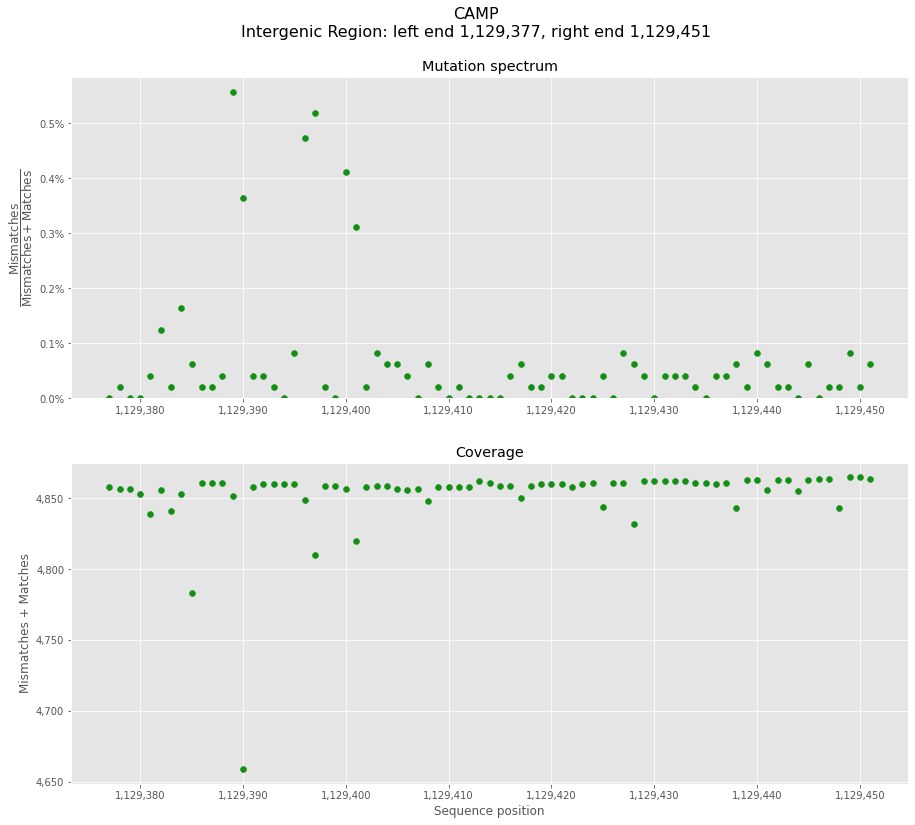

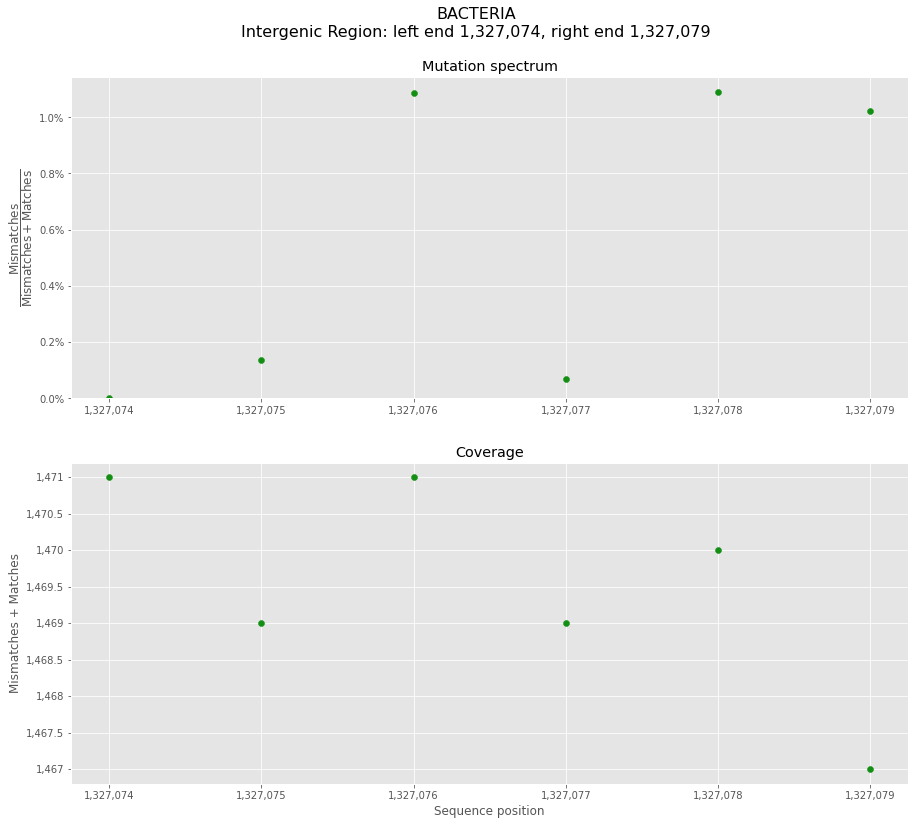

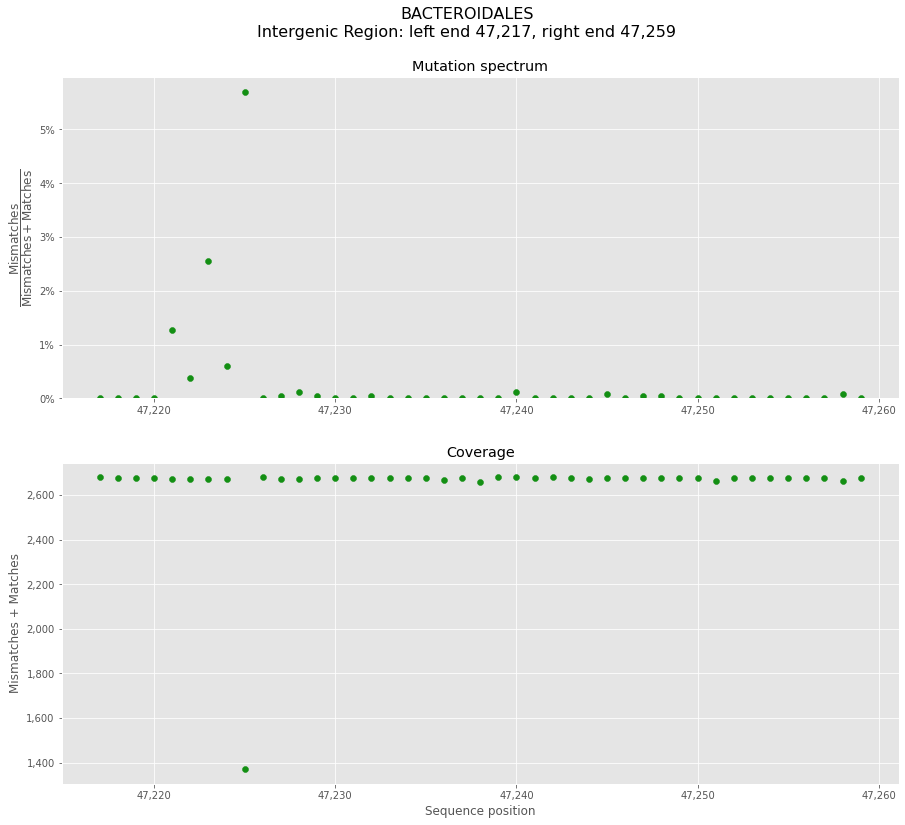

In [46]:
mutation_spectrum_and_coverage_plots("edge_6104", 1129377, 1129451)
mutation_spectrum_and_coverage_plots("edge_1671", 1327074, 1327079)
mutation_spectrum_and_coverage_plots("edge_2358", 47217, 47259)

Maximum mutation rate is 3.89%
The lowest-coverage position in this entire gene has coverage 4,157x.
This gene has an average coverage of 4,393.332518337408x.
...(The sum of all positions' coverages is 1,796,873x, for reference.)


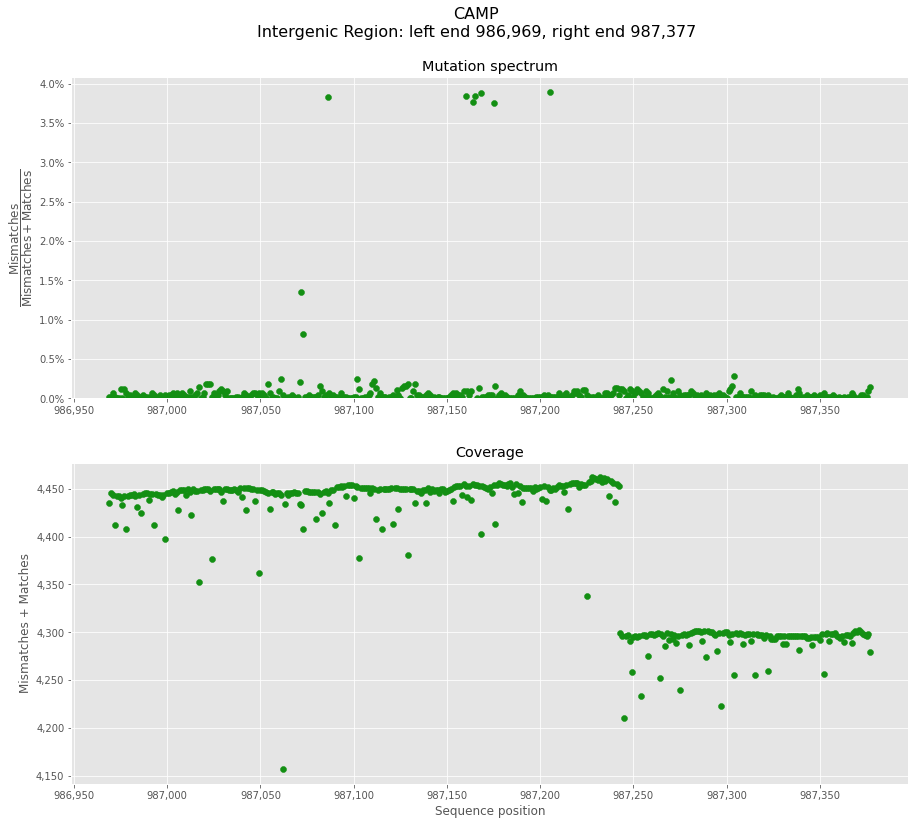

In [47]:
mutation_spectrum_and_coverage_plots("edge_6104", 986969, 987377)

Maximum mutation rate is 5.37%
The lowest-coverage position in this entire gene has coverage 1,416x.
This gene has an average coverage of 1,489.2634730538923x.
...(The sum of all positions' coverages is 497,414x, for reference.)


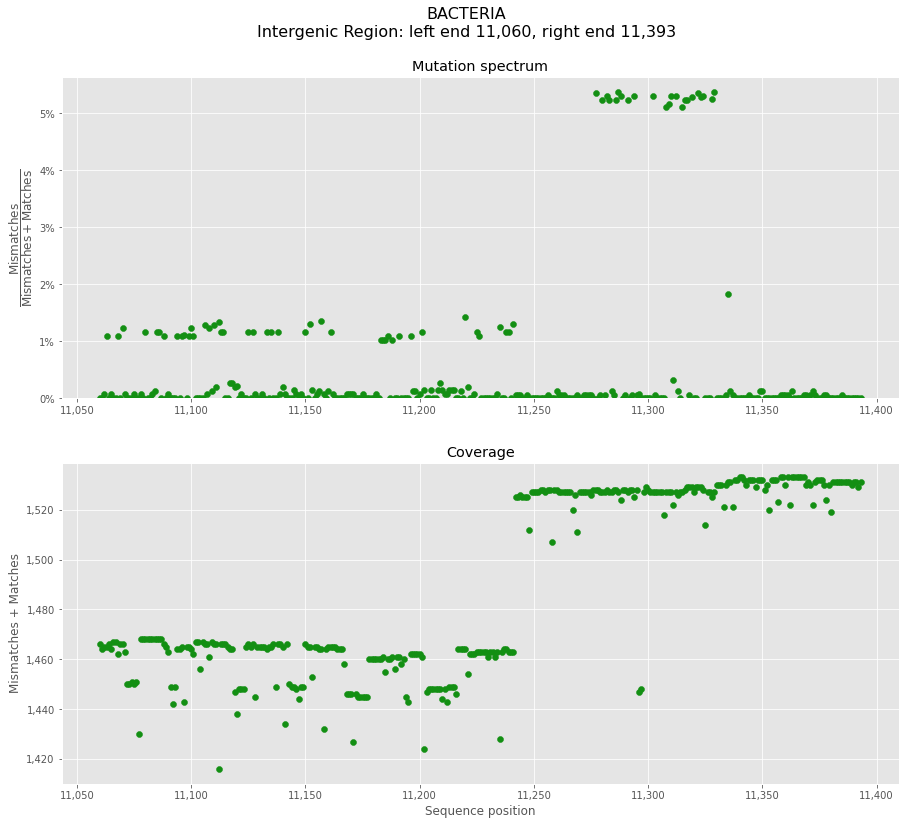

In [49]:
mutation_spectrum_and_coverage_plots("edge_1671", 11060, 11393)

Maximum mutation rate is 1.64%
The lowest-coverage position in this entire gene has coverage 2,739x.
This gene has an average coverage of 2,821.6541554959786x.
...(The sum of all positions' coverages is 1,052,477x, for reference.)


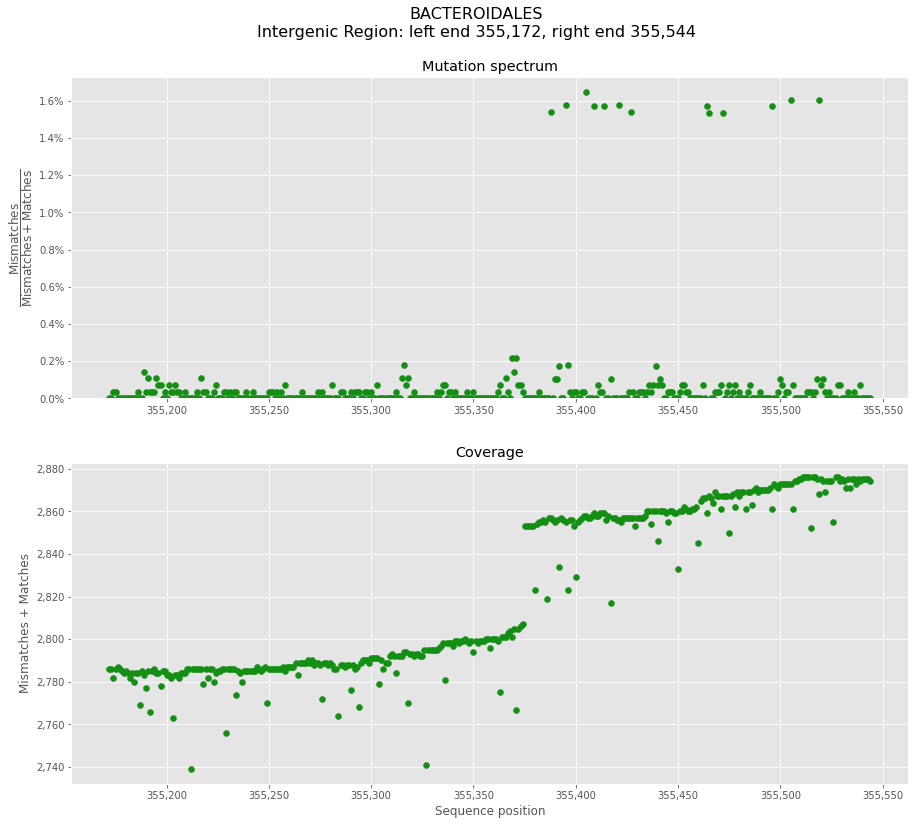

In [48]:
mutation_spectrum_and_coverage_plots("edge_2358", 355172, 355544)